# loading Data

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [3]:
print("Number of images: {}".format(key_pts_frame.shape[0]))

Number of images: 3462


### show some images with the key points

In [4]:
def show_kpts(img, kpts, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.scatter(kpts[:, 0], kpts[:, 1], s=20, marker=".", color="m")

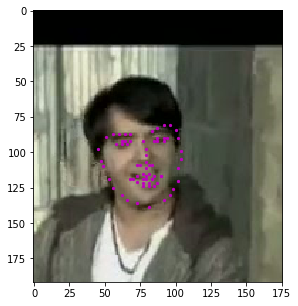

In [5]:
n = 0
img_name = key_pts_frame.iloc[n, 0]
kpts = key_pts_frame.iloc[n, 1:].values
kpts = kpts.astype("float32").reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_kpts(mpimg.imread(os.path.join('data/training/', image_name)), kpts)
plt.show()

In [7]:
grand_mean = key_pts_frame.iloc[:, 1:].values.mean(axis=0)
grand_std = key_pts_frame.iloc[:, 1:].values.std(axis=0)
print(grand_mean.shape, grand_std.shape)
# np.save("grand_mean.npy", grand_mean)
# np.save("grand_std.npy", grand_std)

# grand_mean = 100
# grand_std = 50.

(136,) (136,)


In [8]:
first_feat_mean = key_pts_frame.iloc[:, 1].values.mean()
first_feat_std = key_pts_frame.iloc[:, 1].values.std()
print(first_feat_mean, grand_mean[0])
print(first_feat_std, grand_std[0])

56.96793760831889 56.96793760831889
24.774636688996793 24.774636688996793


In [10]:
example = key_pts_frame.iloc[0, 1:].values
print(np.min(example), np.max(example))
example = (example - grand_mean) / grand_std
print(np.min(example), np.max(example))

45.0 139.0
-0.7036625084898189 0.42695181516817815


In [11]:
np.save("data/grand_mean.npy", grand_mean)
np.save("data/grand_std.npy", grand_std)

### create dataset class for your data

In [12]:
import tensorflow as tf

def normalize(sample, mean, std):
    image, key_pts = sample['image'], sample['keypoints']

    image_copy = np.copy(image)

    # convert image to grayscale
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale color range from [0, 255] to [0, 1]
    image_copy=  image_copy/255.0

    if(key_pts is not None):
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = np.copy(key_pts)
        key_pts_copy = (key_pts_copy - mean)/std

    return {'image': image_copy, 'keypoints': key_pts_copy if key_pts is not None else None }


def rescale(sample, output_size):
    image, key_pts = sample['image'], sample['keypoints']

    h, w = image.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w, new_h))

    if key_pts is not None:
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

    return {'image': img, 'keypoints': key_pts if key_pts is not None else None}


def randomCrop(sample, output_size):
    image, key_pts = sample['image'], sample['keypoints']

    h, w = image.shape[:2]
    new_h, new_w = output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]

    if key_pts is not None:
        key_pts = key_pts - [left, top]

    return {'image': image, 'keypoints': key_pts if key_pts is not None else None}



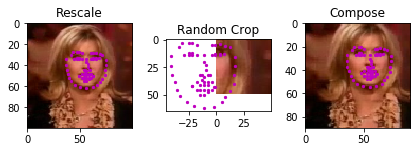

In [13]:
n = 500
img_name = key_pts_frame.iloc[n, 0]
kpts = key_pts_frame.iloc[n, 1:].values
kpts = kpts.astype("float32").reshape(-1, 2)
img = mpimg.imread(os.path.join('data/training/', img_name))
sample = {"image": img, "keypoints": kpts}

# transformed_sample = rescale(sample, (250, 250))
# transformed_sample = randomCrop(transformed_sample, (224, 224))
# transformed_sample['image'].shape

fig = plt.figure()
transformed_sample = rescale(sample, (100, 100))
ax = plt.subplot(1, 3, 1)
plt.tight_layout()
ax.set_title("Rescale")
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

transformed_sample = randomCrop(sample, (50, 50))
ax = plt.subplot(1, 3, 2)
plt.tight_layout()
ax.set_title("Random Crop")
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

transformed_sample = rescale(sample, (100, 100))
transformed_sample = randomCrop(transformed_sample, (90, 90))
ax = plt.subplot(1, 3, 3)
plt.tight_layout()
ax.set_title("Compose")
show_kpts(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [15]:
# grand_mean = 100
# grand_std = 50.

grand_mean = grand_mean.reshape(-1, 2)
grand_std = grand_std.reshape(-1, 2)

In [16]:
from tqdm import tqdm
X = []
y = []
for i in tqdm(range(len(key_pts_frame))):
    img_name = key_pts_frame.iloc[i, 0]
    kpts = key_pts_frame.iloc[i, 1:].values
    kpts = kpts.astype("float32").reshape(-1, 2)
    img = mpimg.imread(os.path.join('data/training/', img_name))
    sample = {"image": img, "keypoints": kpts}
    sample = rescale(sample, (100, 100))
    sample = randomCrop(sample, (90, 90))
    sample = normalize(sample, grand_mean, grand_std)
    X.append(sample['image'])
    y.append(sample['keypoints'].reshape(-1, 1))

100%|██████████| 3462/3462 [00:58<00:00, 58.98it/s]


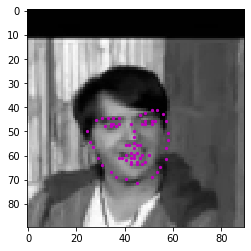

In [17]:
show_kpts(X[0], y[0].reshape(-1, 2) * grand_std + grand_mean, cmap="gray")

In [19]:
## in case you had the images folder
# X = np.array(X)
# y = np.array(y)
# np.save("data/images.npy", X)
# np.save("data/landmarks.npy", y)

## in case you already have the .npy files
X = np.load("data/images.npy")
y = np.load("data/landmarks.npy")


X = X.reshape((3462, 90, 90,1)) # for training purposes
y = y.reshape(3462, 136) # for the same reason, just fixing some dims
X.shape

(3462, 90, 90, 1)

In [20]:
grand_mean = np.load("data/grand_mean.npy")
grand_std = np.load("data/grand_std.npy")

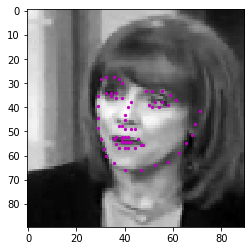

In [22]:
kpts = (y[2] * grand_std) + grand_mean
show_kpts(X[2].reshape(90, 90), kpts.reshape(-1, 2), cmap="gray")

## Creating the model

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), activation="elu", input_shape=[90, 90, 1]),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),
    
    Conv2D(32, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(128, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(256, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(512, (5, 5), activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Flatten(),

    Dense(2048, activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(1024, activation="elu"),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(136)
])

In [ ]:
tf.keras.backend.clear_session()
model.compile(
    loss=tf.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
history = model.fit(X, y, validation_split=0.2, epochs=150)

In [ ]:
img = mpimg.imread(os.path.join('drive/My Drive/', 'test2.jpg'))
sample = rescale({"image": img, "keypoints": None}, (100, 100))
sample = randomCrop(sample, (90, 90))
sample = normalize(sample)
# img = X[0].reshape(90, 90)

kpts = model.predict(img.reshape(1, 90, 90, 1))
show_kpts(img, kpts[0].reshape(-1, 2) * 50 + 100, cmap="gray")